# GAN in Pytorch  

Original Paper: https://arxiv.org/abs/1406.2661  

## Brief notes on GANs  
- Generative model G: captures the data distribution  
- Discriminatice model D: estimates the probability that a sample came from the training data rather than G  
- Related work:  
    - Undirected Graphical models (RBMs) and Deep Belief nets: Untractable partition functions, MCMC takes long time
    - Generative stochastic net: uses parameterized markov chain for sampling. GANs dont use markov chains. Due to this, they dont need feedback loops during generation. So, can better levarage ReLus which improve training.   
- If both G and D are ANNs => adverserial nets  
- D : Train to maximize correct labels to real/fake  
- G : Train to minimize log(1-D(G(z)) ; z -> i/p of G  
- Optimizing D to completion in the inner loop of training is computationally prohibitive, and on finite datasets would result in overfitting. Instead, we alternate between k steps of optimizing D and one step of optimizing G. This results in D being maintained near its optimal solution, so long as G changes slowly enough.  

<img src="gan algo.png" width="700">

**Problem of GAN**  
- D must be synchronized well with G during training (in particular, G must not be trained too much without updating D, in order to avoid “the Helvetica scenario” in which G collapses too many values of z to the same value of x to have enough diversity to model p_data  

**Architecture of the GAN**  
- GANs are known to be very unstable and training them has proven to be difficult.  
- In [this](https://arxiv.org/abs/1511.06434) ICLR 2016 paper, the authors suggested the following to stabilize training GANs.  
- **Architecture guidelines for stable Deep Convolutional GANs  **
    - Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
    - Use batchnorm in both the generator and the discriminator.
    - Remove fully connected hidden layers for deeper architectures.
    - Use ReLU activation in generator for all layers except for the output, which uses Tanh.
    - Use LeakyReLU activation in the discriminator for all layers.




### In this tutorial, I am implementing the DCGAN architecture for generating images from the MNIST dataset. 

In [1]:
# Required modules
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([32, 1, 32, 32]) torch.Size([32])
<class 'torch.Tensor'>


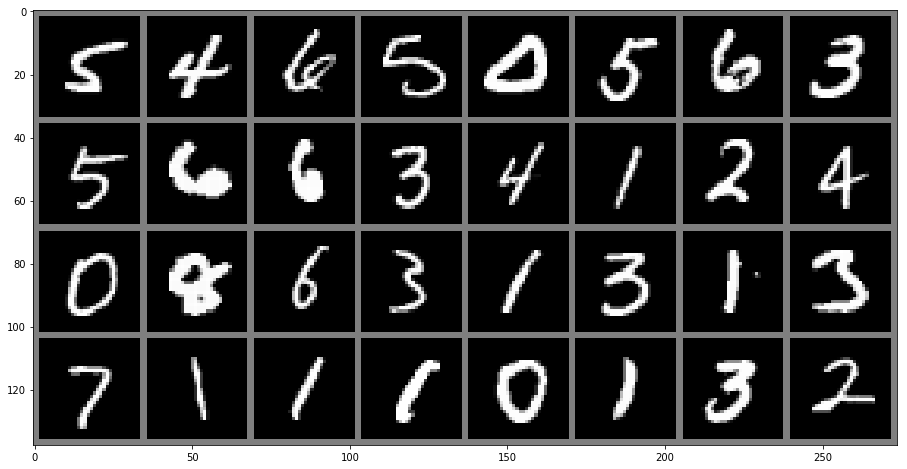

In [48]:
dataset = 'mnist'
batch_size = 32

# Import dataset and create generators
if dataset == 'cifar':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

if dataset == 'mnist':
    transform = transforms.Compose([
        transforms.Pad(padding=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    
# Check the shape of the images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)
print(type(images))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
plt.rcParams['figure.figsize'] = [16, 8]
imshow(torchvision.utils.make_grid(images, nrow=8))

In [3]:
# Model the Generator
class Generator(nn.Module):
    def __init__(self, nc=3, nz=100, ngf=32):
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.model = nn.Sequential(
            # Layer 1: nz x 1 x 1 -> (ngf*4) x 4 x 4
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # Layer 2: (ngf*4) x 4 x 4 -> (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # Layer 3: (ngf*2) x 8 x 8 -> (ngf*1) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Final Layer: (ngf*1) x 16 x 16 -> nc x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.model(input)
    
# Generator Model Summary
netG = Generator(nc=3, nz=100, ngf=32).to(device)
noise = torch.randn(1, 100, 1, 1)
print('input shape = ',noise.shape)
summary(netG.model, (100,1,1))
output = netG.forward(noise)
print('output shape = ',output.shape)

input shape =  torch.Size([1, 100, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]          204800
       BatchNorm2d-2            [-1, 128, 4, 4]             256
              ReLU-3            [-1, 128, 4, 4]               0
   ConvTranspose2d-4             [-1, 64, 8, 8]          131072
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
   ConvTranspose2d-7           [-1, 32, 16, 16]           32768
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              ReLU-9           [-1, 32, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]            1536
             Tanh-11            [-1, 3, 32, 32]               0
Total params: tensor(3.7062e+05)
Trainable params: tensor(3.7062e+05)
Non-trainable params: tensor(0)
-----------------------

In [63]:
# Model the Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=32):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Layer 1 : No batchnorm 
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 2
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 3
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 4
            # nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ndf*8),
            # nn.LeakyReLU(0.2, inplace=True),
            # Final Layer 
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )        
                    
    def forward(self, input):
        output = self.model(input)
        return output.view(-1,1).squeeze(1)

# Discriminator Model Summary
netD = Discriminator(nc=3, ndf=32).to(device)
print('input shape = ',images.shape)
summary(netD.model, (3,32,32))
output = netD.forward(torch.ones(4,3,32,32))
print('output shape = ',output.shape)

input shape =  torch.Size([32, 1, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]            1536
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]           32768
       BatchNorm2d-4             [-1, 64, 8, 8]             128
         LeakyReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 4, 4]          131072
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]            2048
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: tensor(1.6781e+05)
Trainable params: tensor(1.6781e+05)
Non-trainable params: tensor(0)
----------------------------------------------------------------
output shape =  torch

In [52]:
# Train the network
batch_size = 32
nz = 100
nc = 1
ndf = 32
ngf = 32
learn_rate = 0.0002
num_iterations = 1800
real_label = 1
fake_label = 0

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
netG = Generator(nc, nz, ngf).to(device)
netG.apply(weights_init)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=learn_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learn_rate, betas=(0.5, 0.999))


dataiter = iter(trainloader)
for epoch in range(num_iterations):
    ##########################################################
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ##########################################################
    netD.zero_grad()
    
    # Step 1: Get gradients with real data ---------------------------
    # Generate a batch of real data and labels (a list of ones)
    data_real = dataiter.next()[0].to(device)
    labels = torch.full((batch_size,),real_label, device=device)
    # Feed Forward
    output = netD.forward(data_real)
    # Loss: sum over batch of log(D(x))
    lossD_real = criterion(output, labels)
    # Backprop: Update gradients of all parameters wrt lossD_real
    lossD_real.backward()
    D_x = output.mean().item()
    
    # Step 2: Get gradients with fake data -----------------------------
    # Generate a batch of fake data using netG and labels (a list of zeros)
    noise_z = torch.randn(batch_size, nz, 1, 1, device=device)
    data_fake = netG.forward(noise_z)
    labels.fill_(fake_label)
    # Feed Forward in Discriminator 
    # detach data_fake so that gradients of G won't be updated
    output = netD.forward(data_fake.detach())
    # Loss: sum over batch of log(1-D(G(z)))
    lossD_fake = criterion(output, labels)
    # Backprop: Update gradients of all parameters wrt lossD_fake
    # This will add to the gradients of lossD_real
    lossD_fake.backward()
    D_G_z1 = output.mean().item()
    
    loss_D = lossD_real + lossD_fake
    # Step 3: Update the Discriminator -----------------------------
    optimizerD.step()
    
    ##########################################################
    # Update G network: maximize log(D(G(z)))
    ##########################################################
    netG.zero_grad()
    labels.fill_(real_label)
    output = netD.forward(data_fake)
    # Loss: sum over batch of log(D(G(z)))
    lossG = criterion(output, labels)
    # Backprop: Update netG parameters
    # Here, gradients of D are also updated. Since we don't update the 
    # parameters of D and replace them with zeros in the beginning of the 
    # next epoch, the parameters of D wont be updated. 
    # However, we still are calculating extra gradients. How to detach netD
    # from this step? How much speed gain would that lead to?
    lossG.backward()
    D_G_z2 = output.mean().item()
    # Update the Generator -----------------------------------------
    optimizerG.step()    
    
    # Print the loss
    if epoch%100 ==0:
        print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
             % (epoch, num_iterations,
                loss_D.item(), lossG.item(), D_x, D_G_z1, D_G_z2))    

[0/1800] Loss_D: 1.2739 Loss_G: 1.2135 D(x): 0.4862 D(G(z)): 0.3911 / 0.3165
[100/1800] Loss_D: 0.0594 Loss_G: 4.7305 D(x): 0.9717 D(G(z)): 0.0294 / 0.0099
[200/1800] Loss_D: 0.5461 Loss_G: 3.0707 D(x): 0.7491 D(G(z)): 0.1511 / 0.0645
[300/1800] Loss_D: 0.0831 Loss_G: 4.1083 D(x): 0.9321 D(G(z)): 0.0084 / 0.0220
[400/1800] Loss_D: 0.1139 Loss_G: 3.5763 D(x): 0.9516 D(G(z)): 0.0600 / 0.0365
[500/1800] Loss_D: 0.1046 Loss_G: 3.7137 D(x): 0.9547 D(G(z)): 0.0544 / 0.0314
[600/1800] Loss_D: 0.0836 Loss_G: 3.4313 D(x): 0.9554 D(G(z)): 0.0351 / 0.0444
[700/1800] Loss_D: 0.0747 Loss_G: 4.0286 D(x): 0.9745 D(G(z)): 0.0465 / 0.0252
[800/1800] Loss_D: 0.0974 Loss_G: 4.0250 D(x): 0.9803 D(G(z)): 0.0722 / 0.0252
[900/1800] Loss_D: 0.1066 Loss_G: 3.9668 D(x): 0.9681 D(G(z)): 0.0689 / 0.0274
[1000/1800] Loss_D: 0.2914 Loss_G: 3.0036 D(x): 0.7841 D(G(z)): 0.0221 / 0.0714
[1100/1800] Loss_D: 0.4579 Loss_G: 3.2825 D(x): 0.9306 D(G(z)): 0.2955 / 0.0489
[1200/1800] Loss_D: 2.8127 Loss_G: 5.8022 D(x): 0.99

torch.Size([32, 1, 32, 32])
Discriminator predictions: mean = 0.3850, std = 0.1855


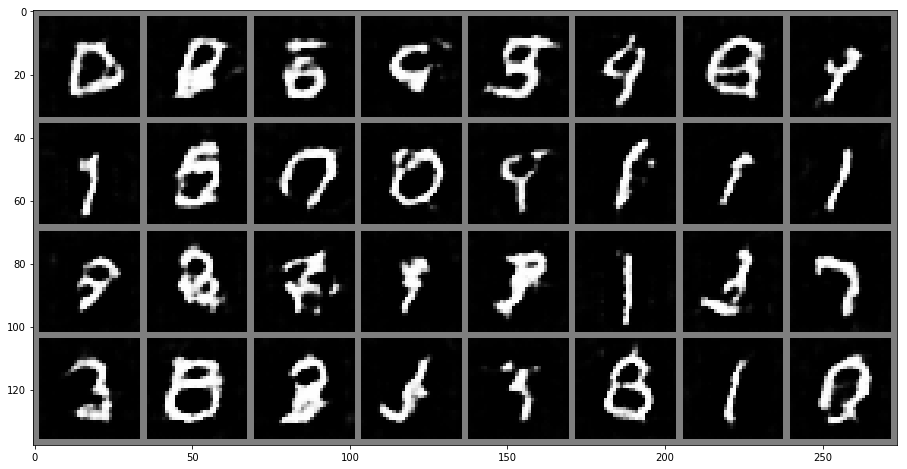

In [62]:
# Print some outputs of the Generator
noise = torch.randn(32,100,1,1)
outputG = netG.forward(noise)
print(outputG.shape)

# Find the output of Discriminator
outputD = netD.forward(outputG)
print('Discriminator predictions: mean = %.4f, std = %.4f'%(outputD.mean().item(),outputD.std().item()))

# Display the generated images
grid = torchvision.utils.make_grid(outputG, nrow=8)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
plt.rcParams['figure.figsize'] = [16, 8]
imshow(grid)

## Final Notes:  
1. It can be observed that even though the discriminator is able to distinguish the fake images with good probability, the images generated still look reasonably good. This shows that the generator was able to learn to generate good images.   
2. The training appeared unstable with the loss of D and G increasing and decreasing abruptly. **How to stabilize it further?**   
3. The model is trained for nc x 32 x 32 images. If it were nc x 64 x 64 instead, it would have been required to add another layer to both generator and discriminator. **How to generalize a GAN architecture to any resolution?**  
4. While finding the gradients of G, the gradients of D are also calculated, even though they are not required. **How to detach D while calculating the gradients of G?**